![Screenshot 2025-06-05 at 1.10.40 PM.png](<attachment:Screenshot 2025-06-05 at 1.10.40 PM.png>)
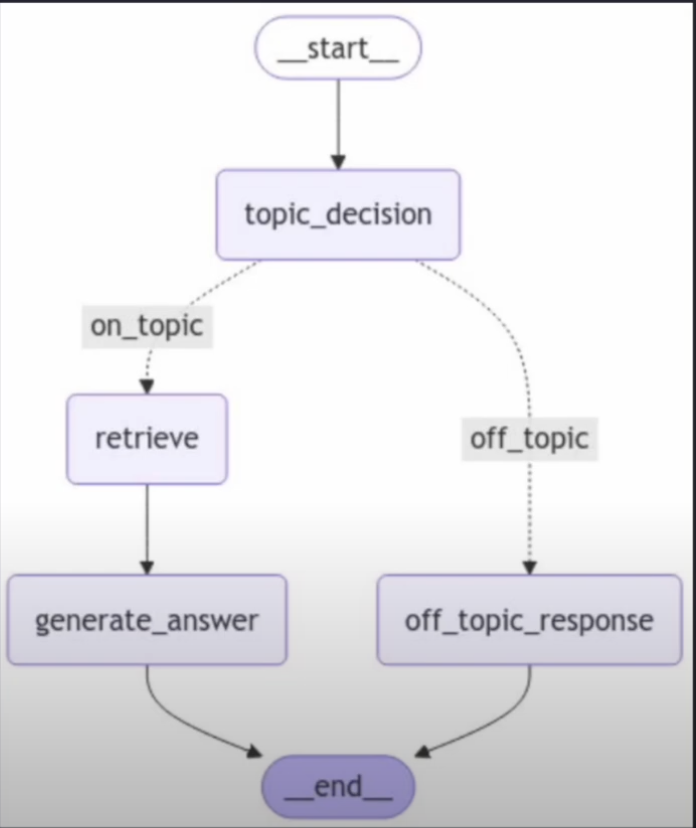

In [84]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

from dotenv import load_dotenv
load_dotenv()

embedding_function = OpenAIEmbeddings()

In [85]:
docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

In [86]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})
# retriever.invoke("who is the owner and what are the timings")

In [87]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based on the following context: {context}
Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [88]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o")

def format_docs(docs):
    return "\n".join(doc.page_content for doc in docs)


# qa_chain = (
#     {
#         "context": lambda x: format_docs(retriever.invoke(x)), 
#         "question": lambda x: x
#     }
#     | prompt 
#     | llm 
#     | StrOutputParser()
# )

rag_chain = prompt | llm

In [89]:
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain.schema import Document
from langgraph.graph import add_messages, StateGraph, END


In [90]:
class RAG_State(TypedDict):
    messages: list[BaseMessage]
    context: list[Document]
    on_topic: str

In [91]:
from pydantic import BaseModel, Field

class Grade_Question(BaseModel):
    """ Boolean value to check whether the question is about the gym or not """
    score: str =  Field(
        description="Question is about the gym if yes --> yes otherwise no"
    )

In [92]:
def question_classifier(state: RAG_State) -> RAG_State:
    """ Classify the question to check if it is about the gym or not """

    question = state["messages"][-1].content
    print(f"Classifying question: {question}")

    system = """ You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    # grading_prompt = ChatPromptTemplate.from_messages(
    #     [
    #         ("system",system),
    #         ("human","User question: {question}")
    #     ]
    # )

    grading_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=system),
            HumanMessage(content=question)
        ]
    )
    print(grading_prompt)

    structured_llm = llm.with_structured_output(Grade_Question)
    grader_llm = grading_prompt | structured_llm
    result = grader_llm.invoke({"question": question})

    print(result)

    state["on_topic"] = result.score
    return state

In [93]:
# def on_topic_router(state: RAG_State) -> RAG_State:
#     """ Route the question based on whether it is about the gym or not """
#     if state["on_topic"] == "Yes":
#         print("Question is on topic, proceeding with RAG chain.")
#         return "on_topic"
#     else:
#         print("Question is off topic, returning 'off_topic'.")
#         return "off_topic"

In [94]:
def on_topic_router(state: RAG_State) -> RAG_State:
    """ Route the question based on whether it is about the gym or not """
    if state["on_topic"] == "Yes":
        print("Question is on topic, proceeding with RAG chain.")
        return "retrieve"
    else:
        print("Question is off topic, returning 'off_topic'.")
        return "off_topic_response"

In [95]:
def retrieve(state: RAG_State) -> RAG_State:
    """ Retrieve relevant documents based on the question """
    question = state["messages"][-1].content
    docs = retriever.invoke(question)
    state["context"] = docs
    return state

In [96]:
def answer_question(state: RAG_State) -> RAG_State:
    """ Answer the question using the retrieved context """
    context = state["context"]
    question = state["messages"][-1].content
    answer = rag_chain.invoke({"context": context, "question": question})
    state["messages"].append(answer)
    return state

In [97]:
def off_topic_response(state: RAG_State) -> RAG_State:
    """ Respond to questions that are not about the gym """
    state["messages"].append(AIMessage(content="I'm sorry, but I can only answer questions related to the gym."))
    return state

In [98]:
workflow = StateGraph(RAG_State)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("answer_question", answer_question)

# workflow.add_conditional_edges(
#     "question_classifier",
#     on_topic_router,
#     {
#         "on_topic": "retrieve",
#         "off_topic": "off_topic_response"
#     }
# )

workflow.add_conditional_edges("question_classifier",on_topic_router)

workflow.add_edge("retrieve", "answer_question")
workflow.add_edge("answer_question", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("question_classifier")

In [99]:
graph = workflow.compile()
initial_state = RAG_State(messages=[HumanMessage(content="who is the owner and what are the timings")], context=[], on_topic="")
result = graph.invoke(initial_state)

Classifying question: who is the owner and what are the timings
input_variables=[] input_types={} partial_variables={} messages=[SystemMessage(content=" You are a classifier that determines whether a user's question is about one of the following topics \n\n    1. Gym History & Founder\n    2. Operating Hours\n    3. Membership Plans \n    4. Fitness Classes\n    5. Personal Trainers\n    6. Facilities & Equipment\n\n    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.\n\n    ", additional_kwargs={}, response_metadata={}), HumanMessage(content='who is the owner and what are the timings', additional_kwargs={}, response_metadata={})]
score='Yes'
Question is on topic, proceeding with RAG chain.


In [100]:
result

{'messages': [HumanMessage(content='who is the owner and what are the timings', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The owner of Peak Performance Gym is Marcus Chen, a former Olympic athlete. The gym is open from Monday through Friday from 5:00 AM to 11:00 PM, and on weekends from 7:00 AM to 9:00 PM. It is closed on major national holidays. However, members with Premium access can enter 24/7, including holidays, using their key cards.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 280, 'total_tokens': 361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BeyanH9BzYgdau7CP6wKDNqlLzRlu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs

In [101]:
initial_state = RAG_State(messages=[HumanMessage(content="who is the ceo of apple")], context=[], on_topic="")
result = graph.invoke(initial_state)

Classifying question: who is the ceo of apple
input_variables=[] input_types={} partial_variables={} messages=[SystemMessage(content=" You are a classifier that determines whether a user's question is about one of the following topics \n\n    1. Gym History & Founder\n    2. Operating Hours\n    3. Membership Plans \n    4. Fitness Classes\n    5. Personal Trainers\n    6. Facilities & Equipment\n\n    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.\n\n    ", additional_kwargs={}, response_metadata={}), HumanMessage(content='who is the ceo of apple', additional_kwargs={}, response_metadata={})]
score='No'
Question is off topic, returning 'off_topic'.
